## STEP 1 : 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
print(df.head())
ts = df['Close']
print(type(ts))
print(ts.head())

<class 'pandas.core.frame.DataFrame'>
              Open    High     Low   Close  Adj Close      Volume
Date                                                             
2000-01-04  6000.0  6110.0  5660.0  6110.0   0.090599  74195000.0
2000-01-05  5800.0  6060.0  5520.0  5580.0   0.082740  74680000.0
2000-01-06  5750.0  5780.0  5580.0  5620.0   0.083333  54390000.0
2000-01-07  5560.0  5670.0  5360.0  5540.0   0.082147  40305000.0
2000-01-10  5600.0  5770.0  5580.0  5770.0   0.085558  46880000.0
<class 'pandas.core.series.Series'>
Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64


## STEP 2 : 각종 전처리 수행

- 결측치 처리
- 로그 변환

In [19]:
# 결측치 확인

ts[ts.isna()]  # Time Series에서 결측치가 있는 부분출력.

Date
2000-12-25   NaN
2001-01-23   NaN
2001-01-24   NaN
2001-01-25   NaN
2001-03-14   NaN
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [20]:
# 결측치 보간. 보간기준 time

ts=ts.interpolate(method='time')
ts[ts.isna()]                    # 다시 NaN 확인

Series([], Name: Close, dtype: float64)

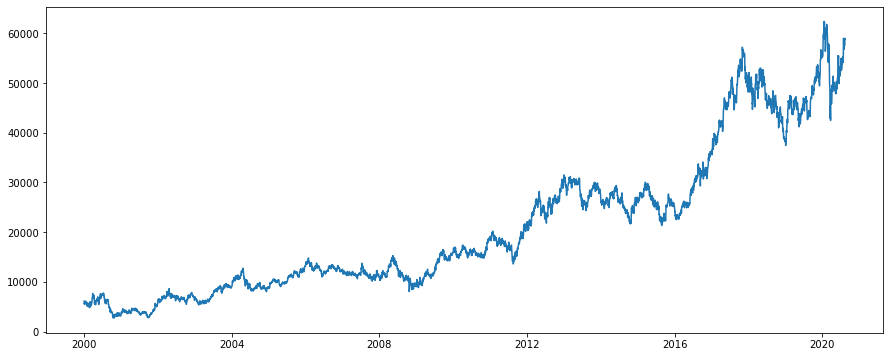

In [21]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    

plt.plot(ts)

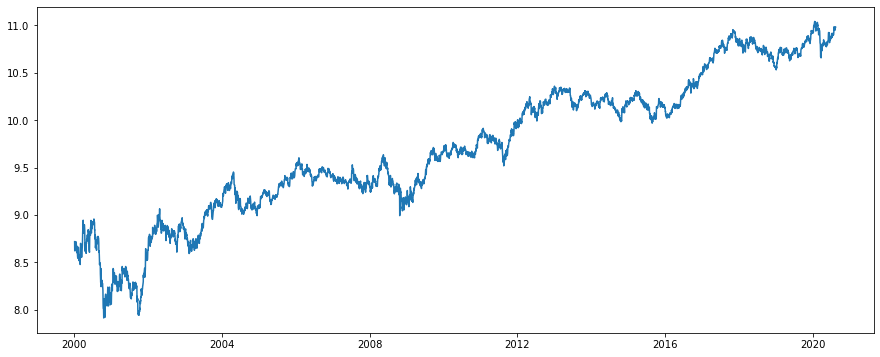

In [24]:
# 로그 변환

ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

-정성적 그래프 분석    
-정량적 Augmented Dicky-Fuller Test    
-시계열 분해(Time Series Decomposition)    
-Residual 안정성 확인    

In [25]:
# Rolling statistics 시각화 함수

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


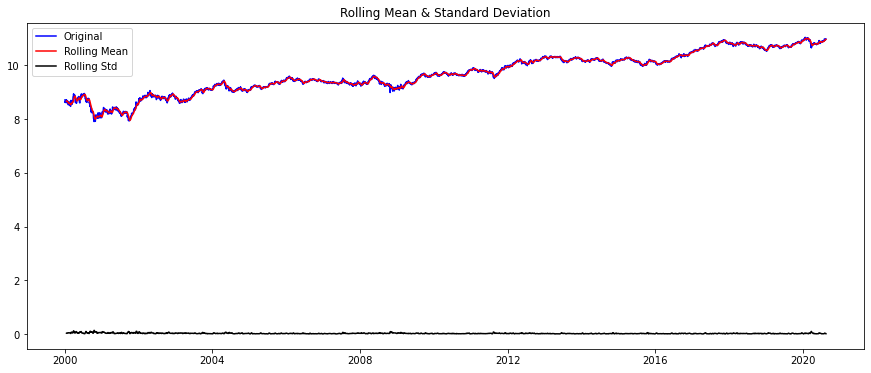

In [26]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [27]:
#정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.683605
p-value                           0.850951
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


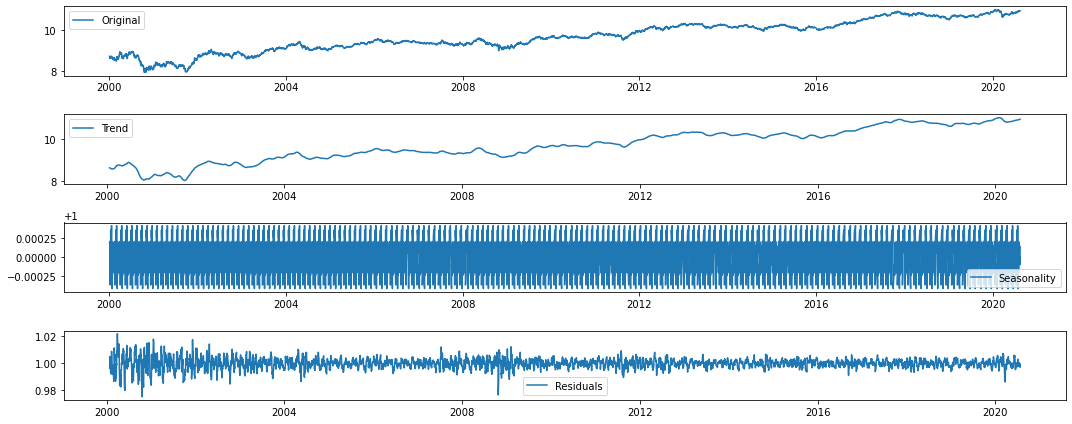

In [28]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

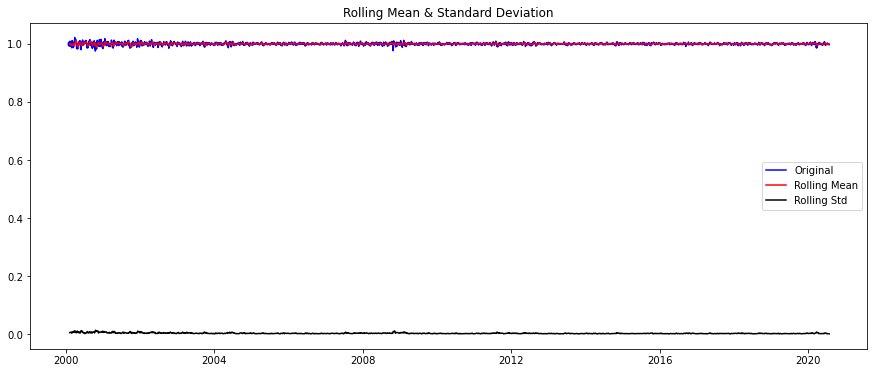

In [29]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

In [31]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.728530e+01
p-value                        5.748569e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리

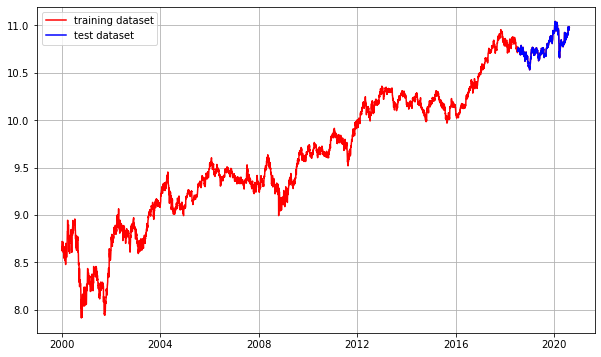

In [32]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

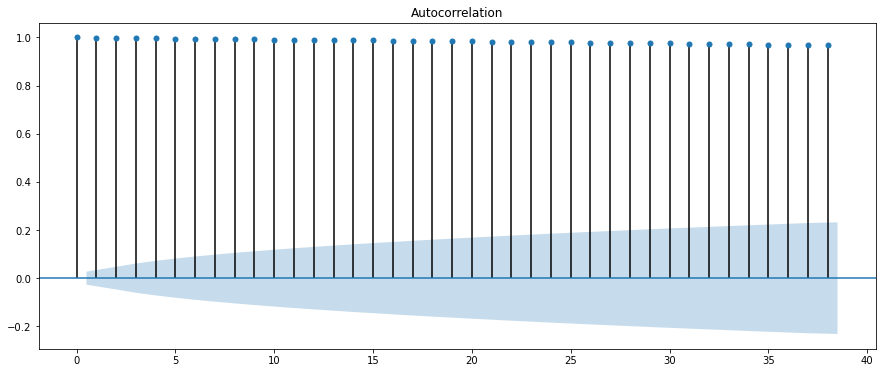

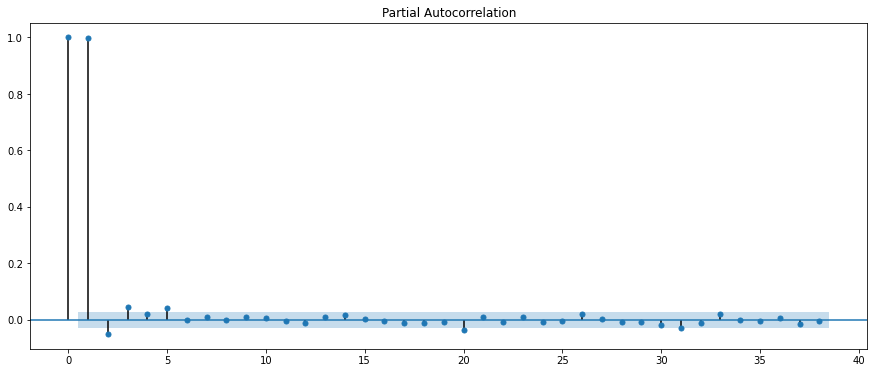

In [33]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -39.817386
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


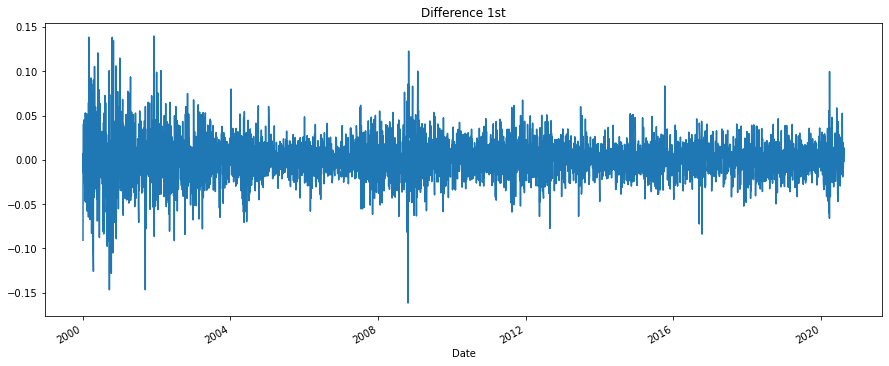

In [34]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [35]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))     # p=1, d=1, q=0
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.285
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                         -21960.569
Time:                        17:05:05   BIC                         -21941.224
Sample:                             1   HQIC                        -21953.765
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0478      0.015      3.262      0.001       0.019       0.076
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


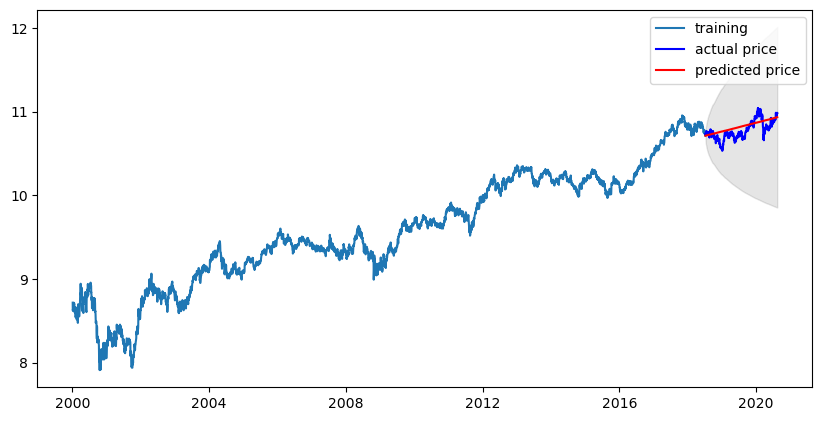

In [36]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18520056.960151263
MAE:  3590.5753583357077
RMSE:  4303.493576171721
MAPE: 7.68%


## STEP 7 : 다른 주식 종목 예측해 보기
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

# Facebook, Inc. (FB)

In [2]:
# 데이터준비, Time Series 생성

dataset_filepath1 = os.getenv('HOME')+'/aiffel/stock_prediction/data/FB.csv'
df1 = pd.read_csv(dataset_filepath1, index_col='Date', parse_dates=True)
print(type(df1))
print(df1.head())
ts1 = df1['Close']
print(type(ts1))
print(ts1.head())

Illegal line #217
	"       - 'Nanum'
"
	in file "/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc"


<class 'pandas.core.frame.DataFrame'>
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-05-18  42.049999  45.000000  38.000000  38.230000  38.230000  573576400
2012-05-21  36.529999  36.660000  33.000000  34.029999  34.029999  168192700
2012-05-22  32.610001  33.590000  30.940001  31.000000  31.000000  101786600
2012-05-23  31.370001  32.500000  31.360001  32.000000  32.000000   73600000
2012-05-24  32.950001  33.209999  31.770000  33.029999  33.029999   50237200
<class 'pandas.core.series.Series'>
Date
2012-05-18    38.230000
2012-05-21    34.029999
2012-05-22    31.000000
2012-05-23    32.000000
2012-05-24    33.029999
Name: Close, dtype: float64


In [3]:
# 결측치 확인

ts1[ts1.isna()] 

Series([], Name: Close, dtype: float64)

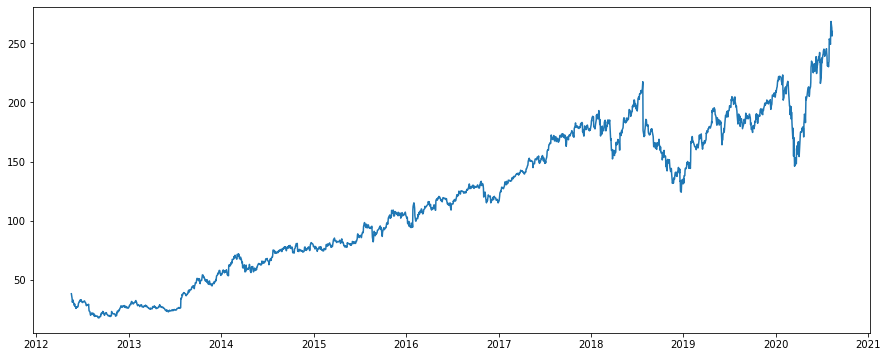

In [4]:
rcParams['figure.figsize'] = 15, 6    

plt.plot(ts1)

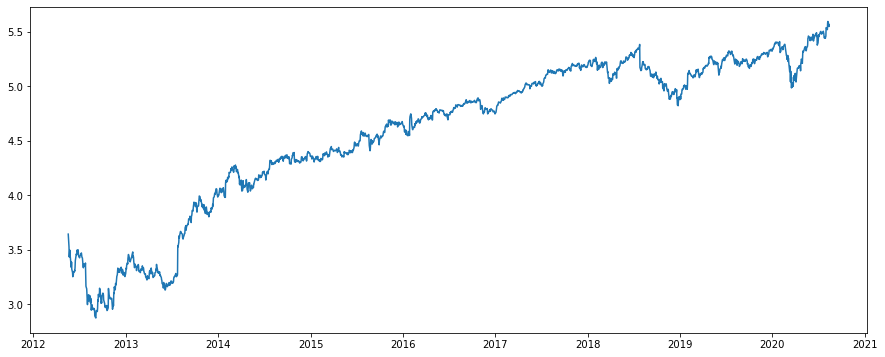

In [5]:
# 로그 변환

ts_log1 = np.log(ts1)
plt.plot(ts_log1)

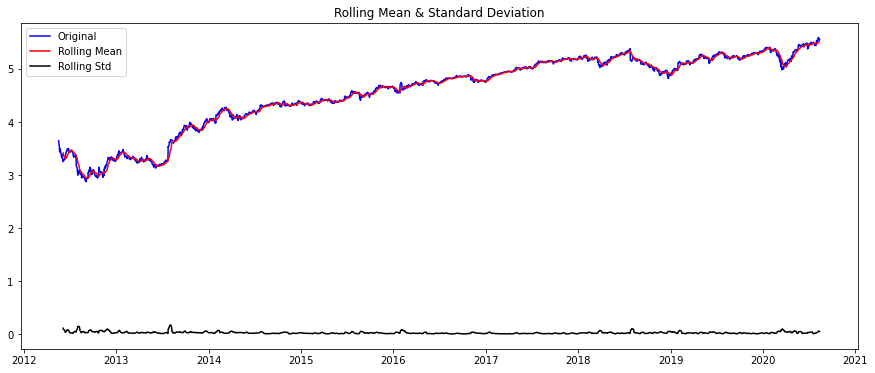

In [8]:
# 정성적 그래프 분석

plot_rolling_statistics(ts_log1, window=12)

In [9]:
#정량적 Augmented Dicky-Fuller Test

augmented_dickey_fuller_test(ts_log1)

Results of Dickey-Fuller Test:
Test Statistic                   -1.182537
p-value                           0.681062
#Lags Used                       10.000000
Number of Observations Used    2061.000000
Critical Value (1%)              -3.433527
Critical Value (5%)              -2.862943
Critical Value (10%)             -2.567517
dtype: float64


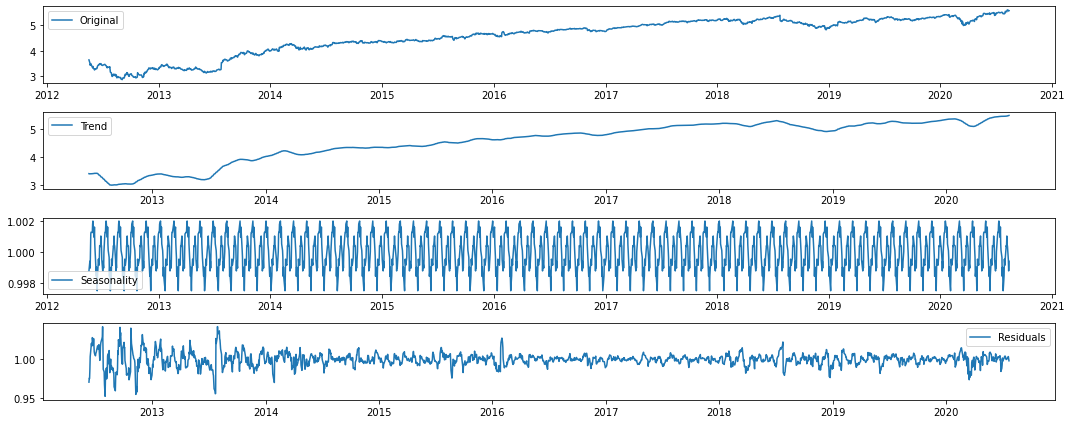

In [10]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log1, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log1, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

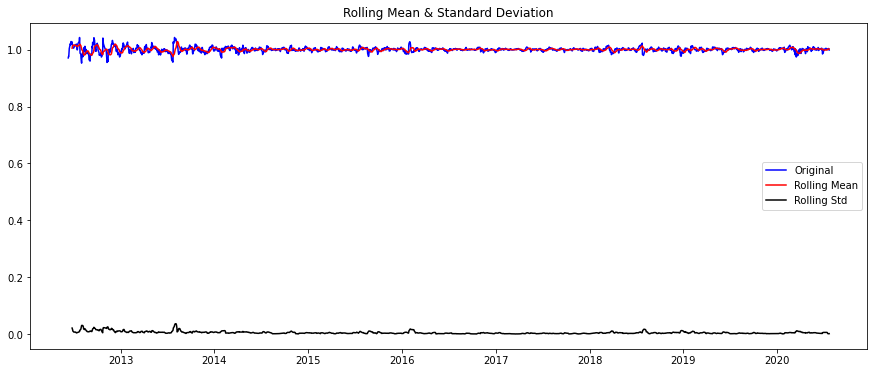

In [11]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

In [12]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.183524e+01
p-value                        7.818997e-22
#Lags Used                     2.600000e+01
Number of Observations Used    2.015000e+03
Critical Value (1%)           -3.433599e+00
Critical Value (5%)           -2.862975e+00
Critical Value (10%)          -2.567534e+00
dtype: float64


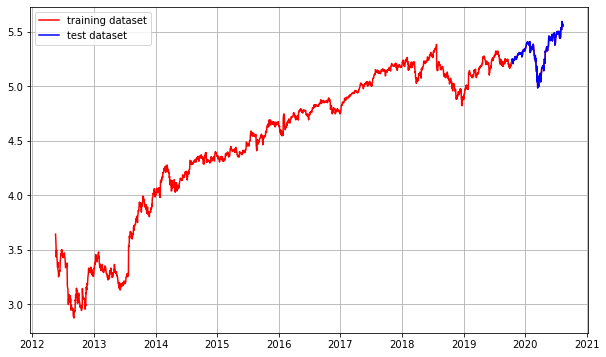

In [13]:
# 데이터 셋 분리

train_data, test_data = ts_log1[:int(len(ts_log1)*0.9)], ts_log1[int(len(ts_log1)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log1, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

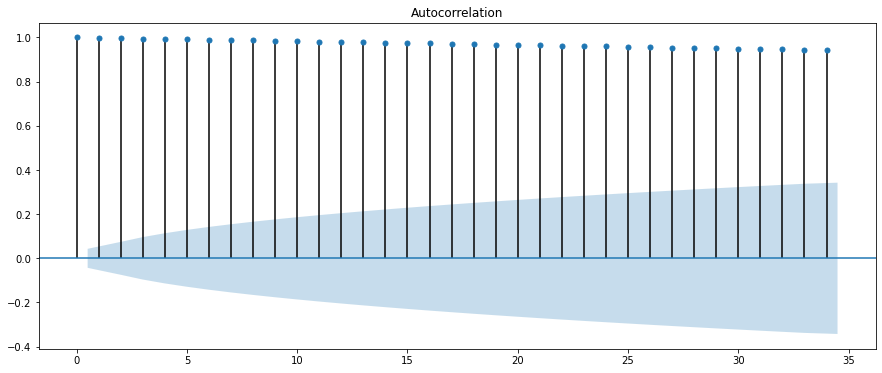

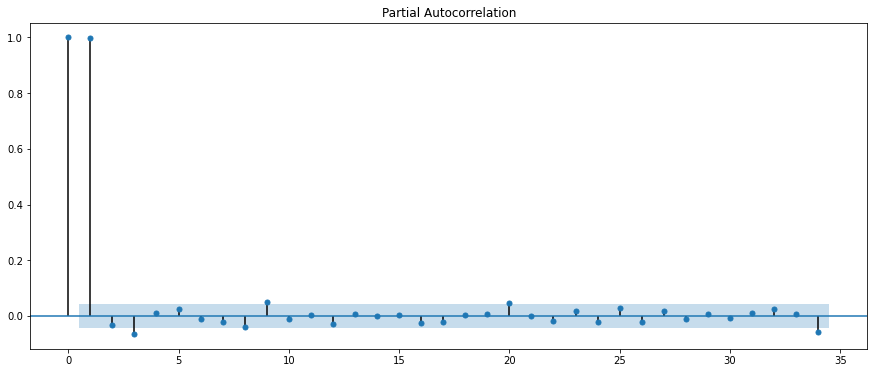

In [14]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.440184e+01
p-value                        8.483075e-27
#Lags Used                     1.000000e+01
Number of Observations Used    2.060000e+03
Critical Value (1%)           -3.433528e+00
Critical Value (5%)           -2.862944e+00
Critical Value (10%)          -2.567517e+00
dtype: float64


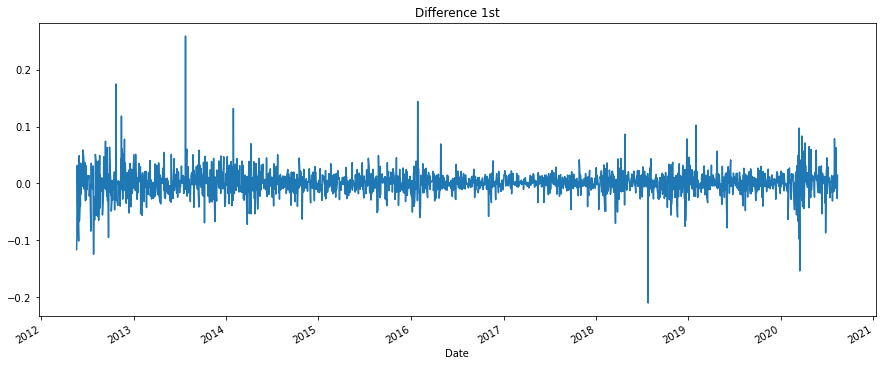

In [15]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log1.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [16]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))     # p=1, d=1, q=0
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1863
Model:                 ARIMA(1, 1, 0)   Log Likelihood                4402.700
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                          -8799.400
Time:                        17:46:32   BIC                          -8782.810
Sample:                             1   HQIC                         -8793.287
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      1.608      0.108      -0.000       0.002
ar.L1.D.Close     0.0099      0.023      0.426      0.670      -0.036       0.056
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


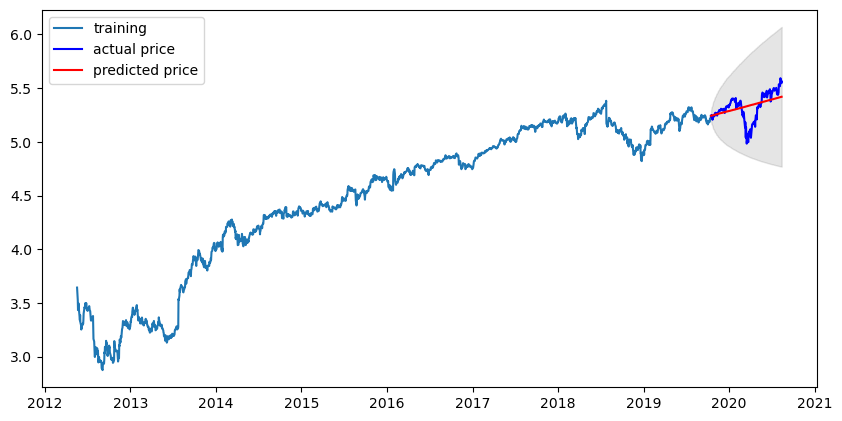

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  487.1576775610934
MAE:  16.678288419252706
RMSE:  22.071648727747853
MAPE: 8.63%


# Alphabet Inc. (GOOG)

In [232]:
# 데이터 준비, Time Series 생성
dataset_filepath2 = os.getenv('HOME')+'/aiffel/stock_prediction/data/GOOG.csv'
df2 = pd.read_csv(dataset_filepath2, index_col='Date', parse_dates=True)
print(type(df2))
print(df2.head())
ts2 = df2['Close']
print(type(ts2))
print(ts2.head())

<class 'pandas.core.frame.DataFrame'>
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2004-08-19  49.813286  51.835709  47.800831  49.982655  49.982655  44871300
2004-08-20  50.316402  54.336334  50.062355  53.952770  53.952770  22942800
2004-08-23  55.168217  56.528118  54.321388  54.495735  54.495735  18342800
2004-08-24  55.412300  55.591629  51.591621  52.239193  52.239193  15319700
2004-08-25  52.284027  53.798351  51.746044  52.802086  52.802086   9232100
<class 'pandas.core.series.Series'>
Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239193
2004-08-25    52.802086
Name: Close, dtype: float64


In [233]:
# 결측치 확인

ts2[ts2.isna()] 

Series([], Name: Close, dtype: float64)

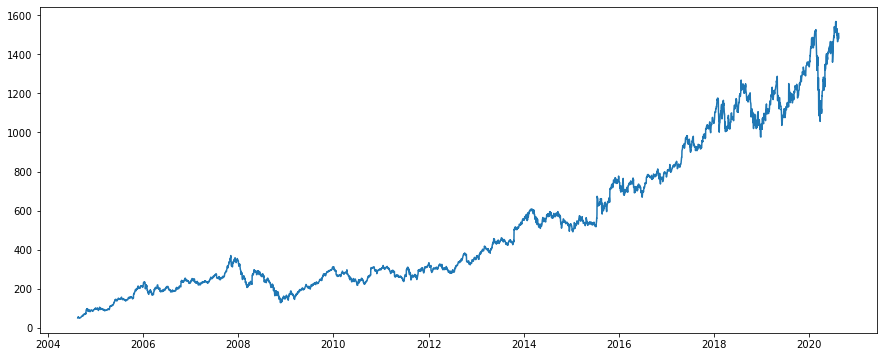

In [234]:
rcParams['figure.figsize'] = 15, 6    

plt.plot(ts2)

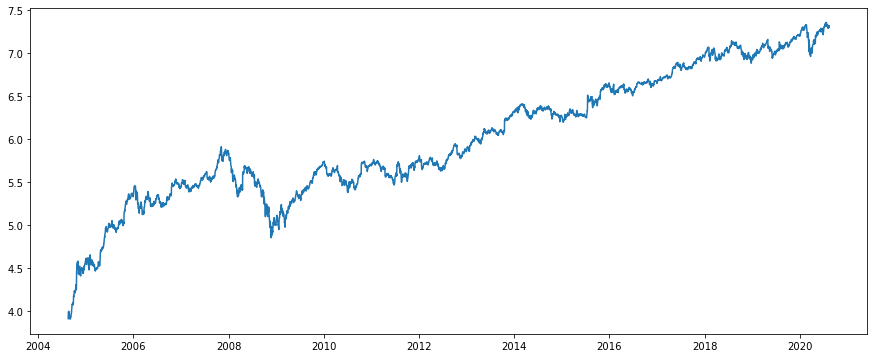

In [235]:
# 로그 변환

ts_log2 = np.log(ts2)
plt.plot(ts_log2)

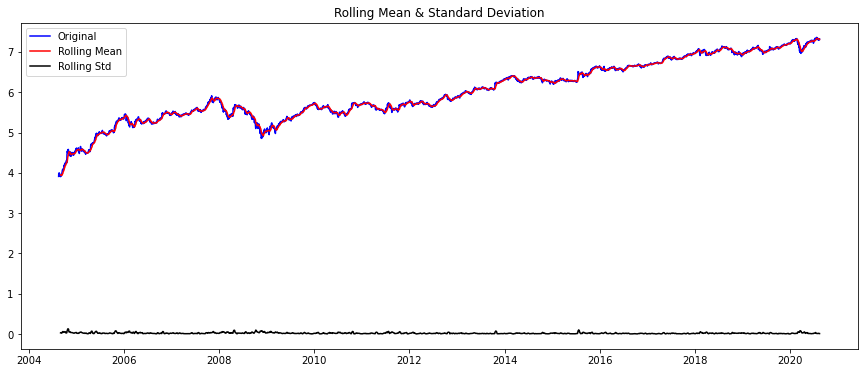

In [236]:
# 정성적 그래프 분석

plot_rolling_statistics(ts_log2, window=12)

In [237]:
#정량적 Augmented Dicky-Fuller Test

augmented_dickey_fuller_test(ts_log2)

Results of Dickey-Fuller Test:
Test Statistic                   -2.296705
p-value                           0.173033
#Lags Used                       12.000000
Number of Observations Used    4011.000000
Critical Value (1%)              -3.431981
Critical Value (5%)              -2.862261
Critical Value (10%)             -2.567154
dtype: float64


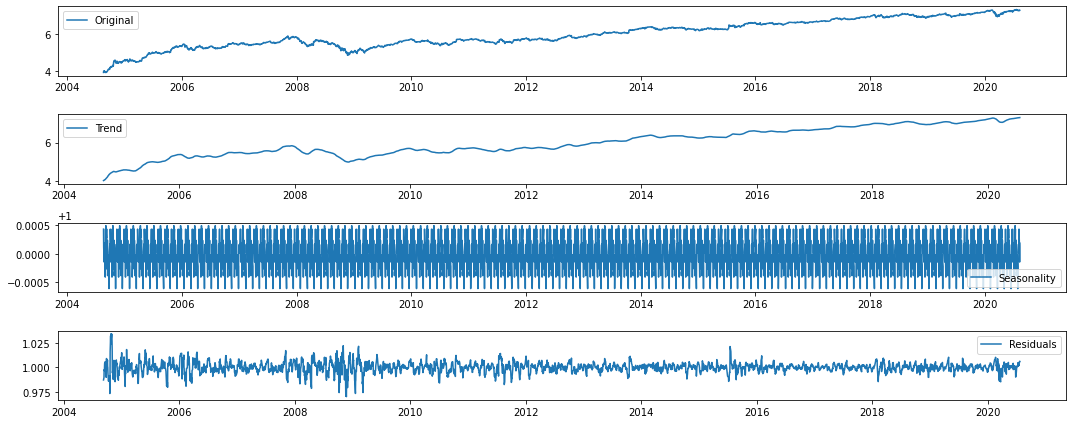

In [238]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log2, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

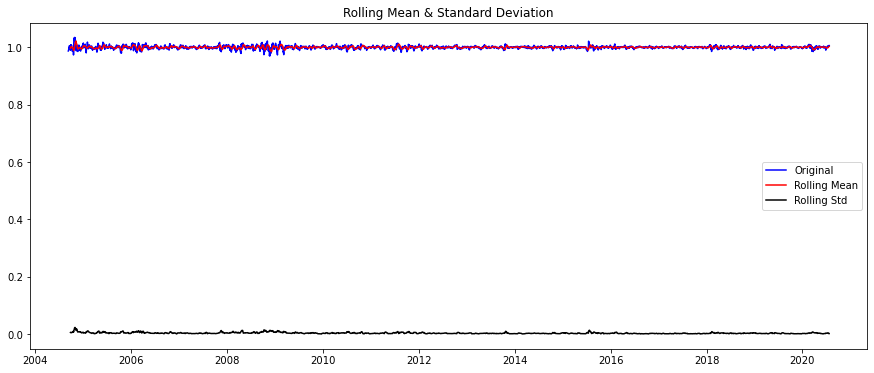

In [239]:
# Residual 안정성 확인

plot_rolling_statistics(residual)

In [240]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.465120e+01
p-value                        3.498179e-27
#Lags Used                     3.000000e+01
Number of Observations Used    3.963000e+03
Critical Value (1%)           -3.432001e+00
Critical Value (5%)           -2.862270e+00
Critical Value (10%)          -2.567158e+00
dtype: float64


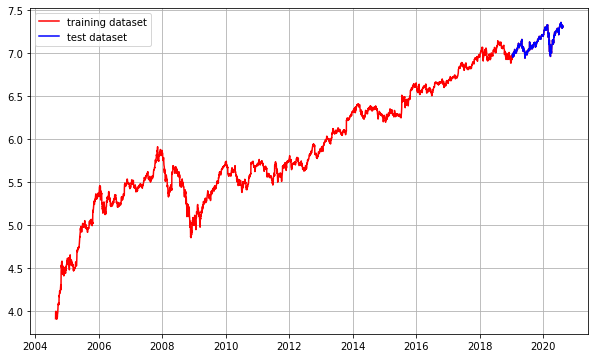

In [241]:
train_data, test_data = ts_log2[:int(len(ts_log2)*0.9)], ts_log2[int(len(ts_log2)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log2, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

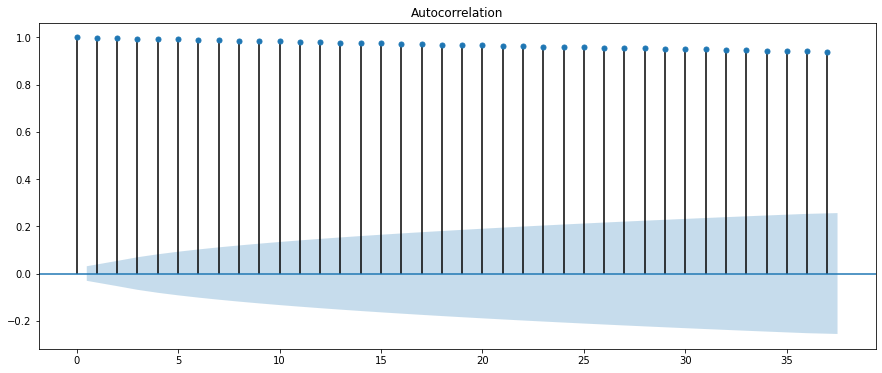

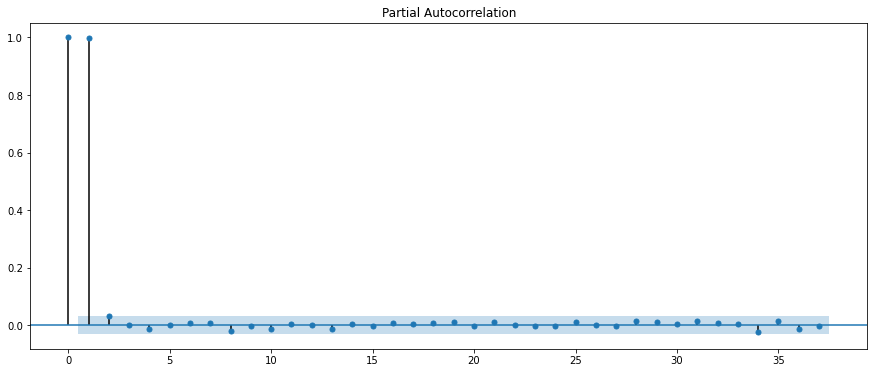

In [242]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.760902e+01
p-value                        3.887867e-30
#Lags Used                     1.100000e+01
Number of Observations Used    4.011000e+03
Critical Value (1%)           -3.431981e+00
Critical Value (5%)           -2.862261e+00
Critical Value (10%)          -2.567154e+00
dtype: float64


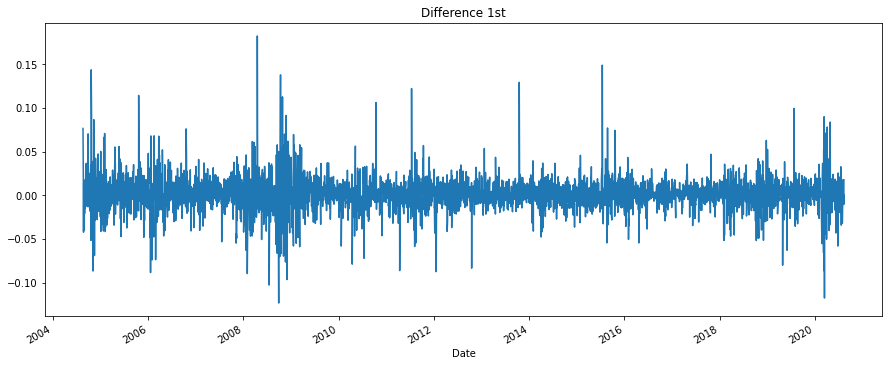

In [243]:
# 차분 안정성 확인 -> d 구하기

diff_1 = ts_log2.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [244]:
# Build and Train  Model

model = ARIMA(train_data, order=(1, 1, 0))    # p=1, d=1, q=0
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3620
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9211.049
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 Aug 2020   AIC                         -18416.097
Time:                        21:25:00   BIC                         -18397.515
Sample:                             1   HQIC                        -18409.477
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.656      0.008       0.000       0.001
ar.L1.D.Close     0.0087      0.017      0.522      0.602      -0.024       0.041
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


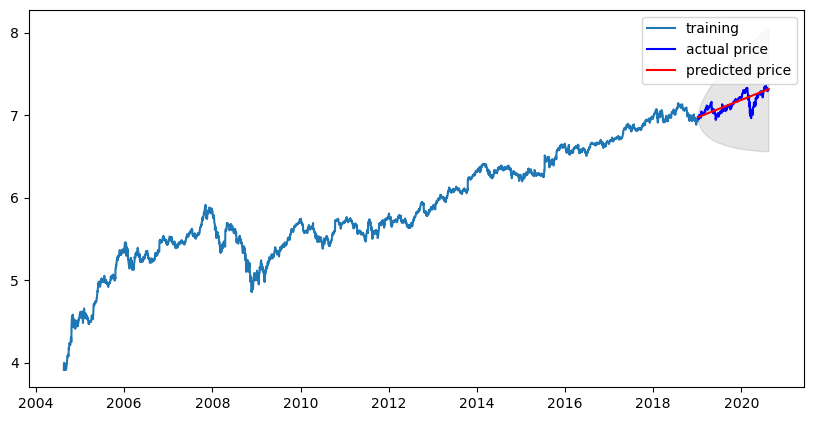

In [245]:
# Forecast 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) 

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [246]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7697.223371738794
MAE:  62.38887827130351
RMSE:  87.73382113950579
MAPE: 5.04%


# SK Telecom Co.,Ltd (017670.KS)

In [200]:
# 데이터준비, Time Series 생성

dataset_filepath3 = os.getenv('HOME')+'/aiffel/stock_prediction/data/017670.KS.csv'
df3 = pd.read_csv(dataset_filepath3, index_col='Date', parse_dates=True)
print(type(df3))
print(df3.head())
ts3 = df3['Close']
print(type(ts3))
print(ts3.head())

<class 'pandas.core.frame.DataFrame'>
                Open      High       Low     Close      Adj Close    Volume
Date                                                                       
2000-01-04  390100.0  405000.0  347000.0  380000.0  209956.234375  359000.0
2000-01-05  323000.0  365000.0  323000.0  323000.0  178462.781250  572000.0
2000-01-06  350000.0  352000.0  322500.0  328700.0  181612.140625  418000.0
2000-01-07  308000.0  350000.0  307000.0  336000.0  185645.484375  342000.0
2000-01-10  360000.0  383000.0  355000.0  370000.0  204431.078125  270000.0
<class 'pandas.core.series.Series'>
Date
2000-01-04    380000.0
2000-01-05    323000.0
2000-01-06    328700.0
2000-01-07    336000.0
2000-01-10    370000.0
Name: Close, dtype: float64


In [201]:
# 결측치 확인

ts3[ts3.isna()] 

Date
2000-12-25   NaN
2001-01-23   NaN
2001-01-24   NaN
2001-01-25   NaN
2001-03-14   NaN
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [202]:
# # # 결측치 보간. 보간기준 time

ts3=ts3.interpolate(method='time')
ts3[ts3.isna()]   

Series([], Name: Close, dtype: float64)

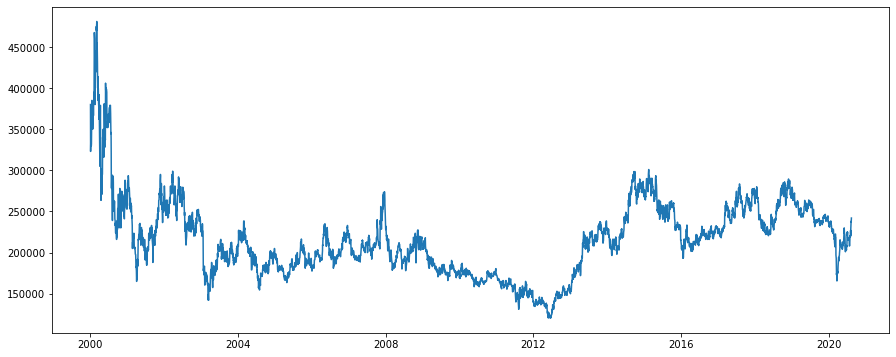

In [203]:
rcParams['figure.figsize'] = 15, 6    

plt.plot(ts3)

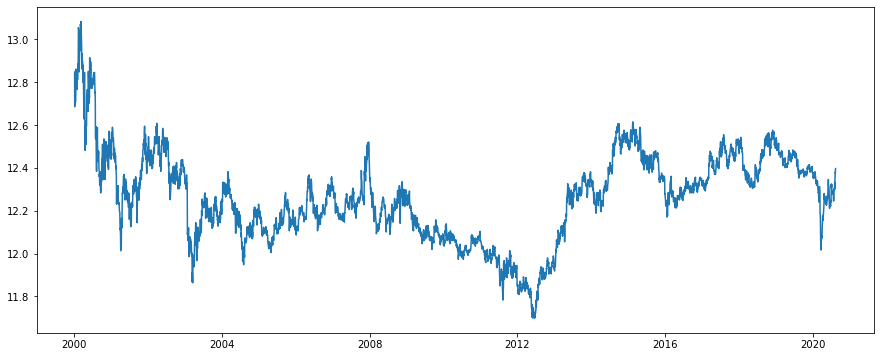

In [204]:
# 로그 변환

ts_log3 = np.log(ts3)
plt.plot(ts_log3)

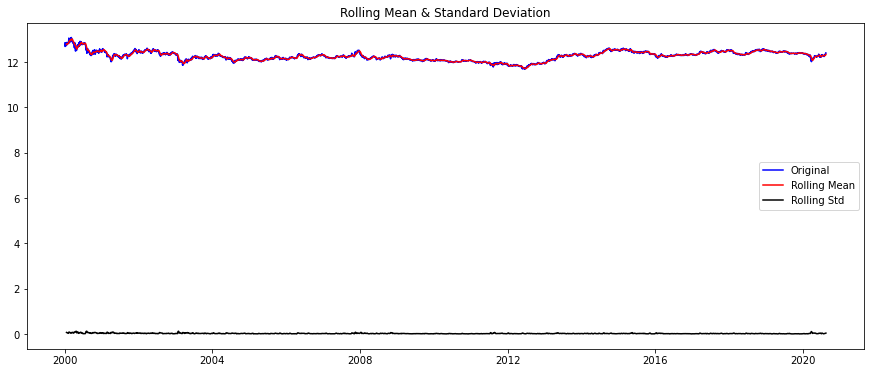

In [205]:
# 정성적 그래프 분석

plot_rolling_statistics(ts_log3, window=12)

In [206]:
#정량적 Augmented Dicky-Fuller Test

augmented_dickey_fuller_test(ts_log3)

Results of Dickey-Fuller Test:
Test Statistic                   -3.420856
p-value                           0.010268
#Lags Used                       15.000000
Number of Observations Used    5171.000000
Critical Value (1%)              -3.431615
Critical Value (5%)              -2.862099
Critical Value (10%)             -2.567068
dtype: float64


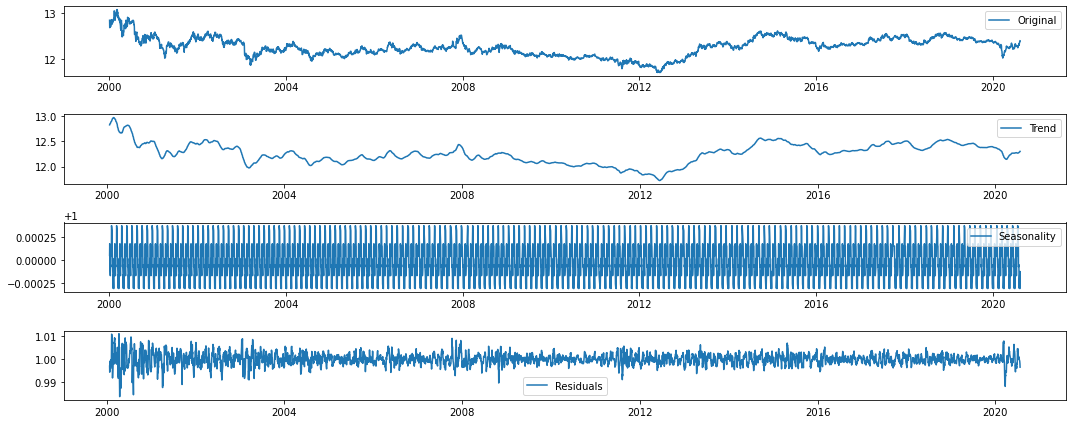

In [207]:
#시계열 분해 (Time Series Decomposition)
# model='multiplicative'
decomposition = seasonal_decompose(ts_log3, model='multiplicative',period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log3, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

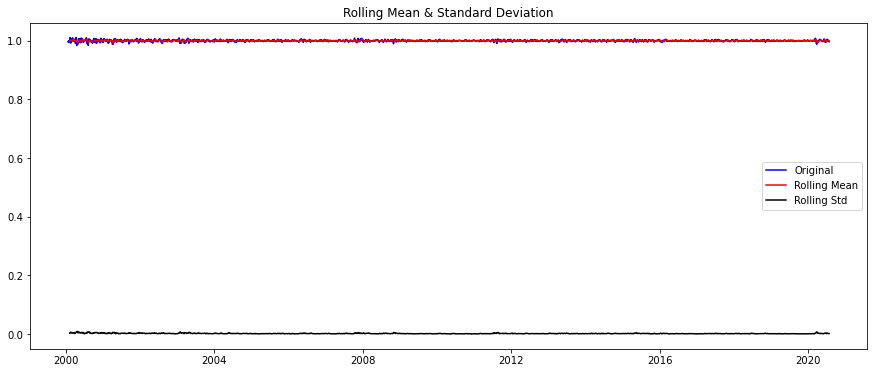

In [208]:
# Residual 안정성 확인

plot_rolling_statistics(residual)

In [209]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.707543e+01
p-value                        7.772722e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


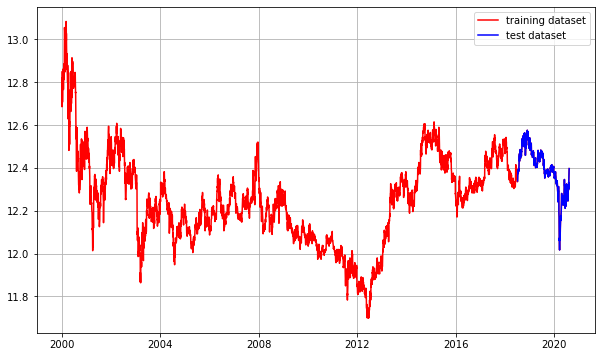

In [210]:
# 데이터 셋 분리

train_data, test_data = ts_log3[:int(len(ts_log3)*0.9)], ts_log3[int(len(ts_log3)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log3, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

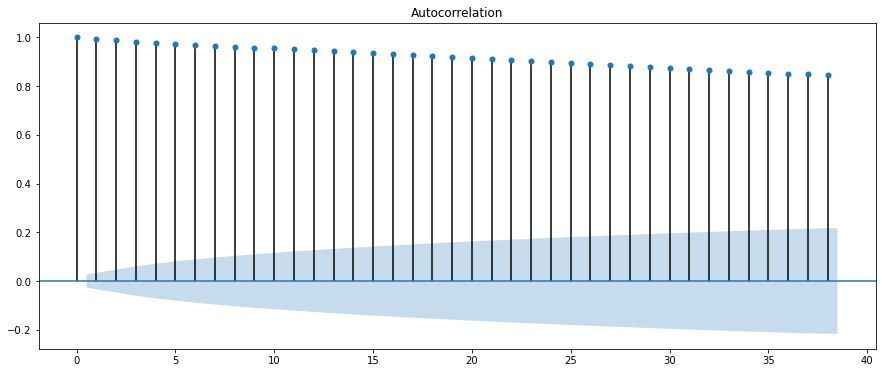

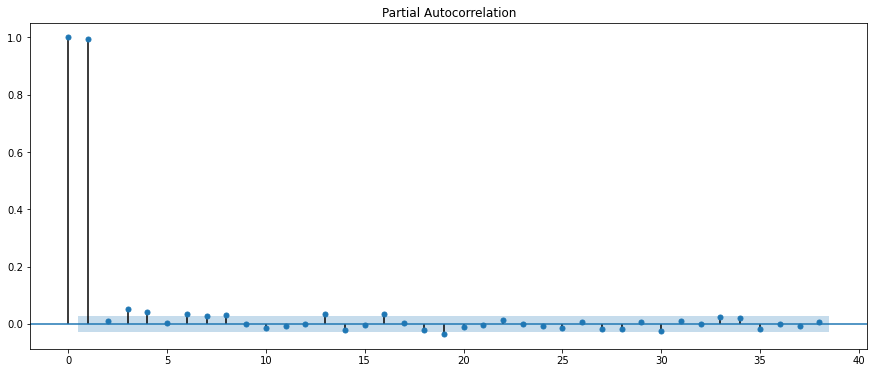

In [211]:
# ACF, PACF 그려보기 -> p,q 구하기


plot_acf(ts_log3)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log3)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -20.443377
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    5171.000000
Critical Value (1%)              -3.431615
Critical Value (5%)              -2.862099
Critical Value (10%)             -2.567068
dtype: float64


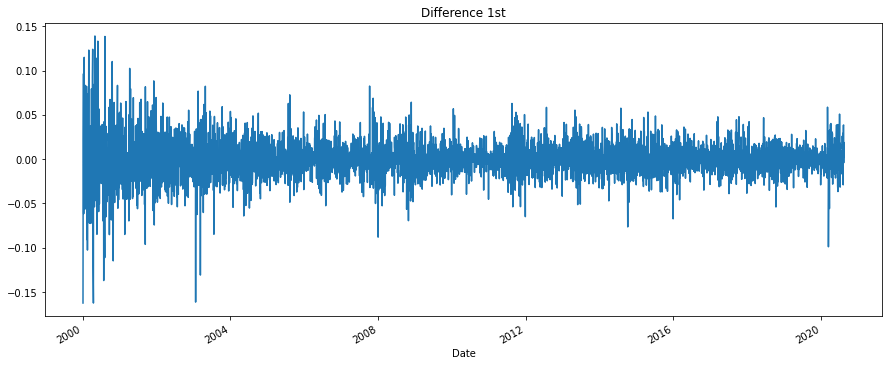

In [212]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log3.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [229]:
model = ARIMA(train_data, order=(0, 1, 12))     # q변경
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                ARIMA(0, 1, 12)   Log Likelihood               11410.763
Method:                       css-mle   S.D. of innovations              0.021
Date:                Thu, 13 Aug 2020   AIC                         -22793.527
Time:                        21:16:04   BIC                         -22703.251
Sample:                             1   HQIC                        -22761.776
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0001      0.000     -0.442      0.659      -0.001       0.000
ma.L1.D.Close      0.0271      0.015      1.837      0.066      -0.002       0.056
ma.L2.D.Close     -0.0803      0.015

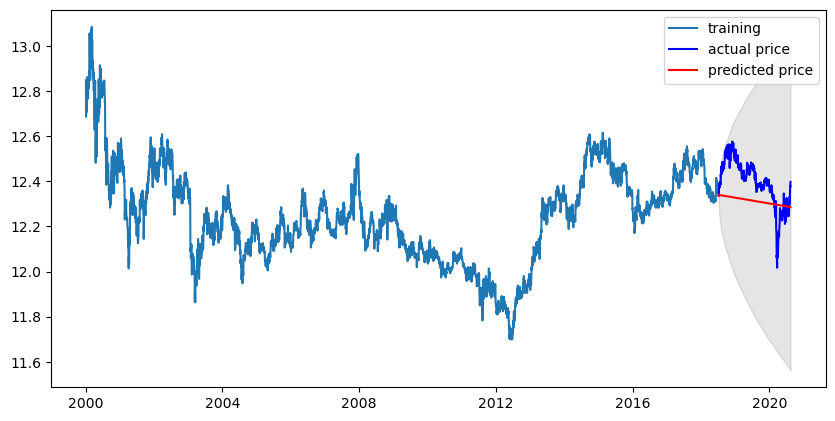

In [230]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [231]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  873790858.6424664
MAE:  25370.650360472693
RMSE:  29559.953630587217
MAPE: 10.17%


데이터 전처리........    
삼성데이터로 노드에서 배운 내용을 적용과 복습을 하면서, 정리가 될 수 있었다.   
페이스북으로 종목을 변경해서 해보았더니, MAPE: 8.63%으로 평가기준 10%미만을 만족하여,
다음 트위터, 디즈니, 네이버, 넷플릭스, 카카오 등등 다 10%가 넘는 것이다..  
ARIMA에서 p값, d값, q값을 바꿔바도 10% 밑으로는 나오질 않는다.  
노드에서 p*q =0, p+q = 2 기준을 봐서 그 기준으로 바꿨었는데, 노드 끝부분에는 q값을 8이나 그 이상 수를 변경해봐도 수치가 변할것이라는데, 거기에대한 설명이 부족했다.
그래서 주변에 물어 10%미만인 종목을 찾아.. 점점 학습목표?와 동떨어진 방향이되버린 느낌이지만, 별을 받아야하니...!!!!   
그래도 10% 밑으로 해보겠다고 이거저거 숫자변경해가면서, 재미는 있었지만, 왜 값이 이렇게 바뀐건지 잘 알 수 없었고, 이 데이터 처리가 잘 된건지 판단할수 있는 밑에 나오는 표를 내 수준에서는 p-value밖에 볼수없어서, 답답했다. 노드에서 결과값에 대한 다른 수치들도 설명해줬으면 더 좋았을 것 같다.   

결국 skt를   
p=1, d=1, q=0 ==> MAPE: 22.47%
p=0, d=1, q=12 ==> MAPE: 10.17%   
끝까지 붙잡아봤지만, 10.17이 최선이었다.    

삼성, 페이스북, 구글은 10% 미만.
skt는 10.17 

통계를 추가적으로 공부를 해야겠다..........